In [1]:
import os,sys
from PIL import Image
from rembg import remove
import numpy as np
import pandas as pd

In [107]:
class image_proc:
    def __init__(self,img_dir,output_dir):
        self.img_dir = img_dir
        self.output_dir = output_dir
        self.imgs = []
        return
    
    def load_imgs(self):
        if self.imgs: return
        for i in os.listdir(self.img_dir):
            tmp = Image.open(os.path.join(self.img_dir,i))
            self.imgs.append(tmp)
        return 
    
    def remove_background(self):
        self.load_imgs()
        for i in range(len(self.imgs)):
            tmp = self.imgs[i]
            self.imgs[i] = remove(tmp)
            self.imgs[i].filename = tmp.filename
        return
    
    def crop_invis(self):
        self.load_imgs()
        for i in range(len(self.imgs)):
            tmp = self.imgs[i]
            mask = np.array(tmp.split()[-1])>0
            length = np.where(np.any(mask,axis=0))[0]
            height = np.where(np.any(mask,axis=1))[0]
            box = length[0], height[0], length[-1], height[-1]
            self.imgs[i] = tmp.crop(box)
            self.imgs[i].filename = tmp.filename
        return
    
    def save(self):
        for i in self.imgs:
            name = i.filename.split('/')[-1].split('.')[0] + '.png'
            i.save(os.path.join(self.output_dir,name))
        return
    
    def proc_save(self):
        #preprocessors-
        self.remove_background()
        self.crop_invis()
        
        #saving files
        self.save()
        return

In [108]:
process = image_proc('images','processed_imgs')
process.proc_save()

In [271]:
class imagegen:
    '''
    This image generator will generate images based on random selection of images
    '''

    def __init__(self,img_dir,max_imgs,output_dim, background=None):
        self.n_imgs = 0
        self.imgs_selected = []
        self.imgs = []
        
        self.max_imgs = max_imgs
        self.img_dir = img_dir
        self.output_dim = output_dim
        self.background = background
        if self.background:
            self.canvas = Image.open(self.background).resize(self.output_dim)
        else:
            self.canvas = Image.new('RGB',self.output_dim,0)

        return
    
    def select_images(self):
        self.n_imgs = np.random.choice(range(2,self.max_imgs), 1)
        print(f'{self.n_imgs} images were selected')
        
        self.imgs = np.array(os.listdir(self.img_dir))
        selected_ind = np.random.choice(len(self.imgs),size=self.n_imgs,replace=False)
        print(f'{selected_ind} were the indices that were selected')
        self.imgs_selected = []
        for ind in selected_ind:
            path = os.path.join(self.img_dir,self.imgs[ind])
            tmp = Image.open(path)
            self.imgs_selected.append(tmp)
        return
    
    def get_newsize(self,img,canvas,size_perc):
        ratio_img = img.size[0]/img.size[1]
        ratio_canvas = canvas.size[0]/canvas.size[1]
        
        if ratio_img > ratio_canvas:
            canvasfit = (canvas.size[0],int(canvas.size[0]/ratio_img))
        else:
            canvasfit = (int(canvas.size[1]*ratio_img),canvas.size[1])
            
        new_size = int(canvasfit[0]*size_perc), int(canvasfit[1]*size_perc)
        
        return new_size
    
    def position_possible(self,position,positions_excluded):
        
        for pos in positions_excluded:
            if not(position[0] > pos[2] or pos[0] > position[2]):
                return False
            
            if not(position[3] > pos[1] or pos[3] > position[1]):
                return False

        return True
        
    def get_position(self, canvas_size,img_size, possible_positions,positions_excluded):
        
        pos_bound = canvas_size[0] - img_size[0], \
                    canvas_size[1] - img_size[1]        
        
        ind_pos = []
        for i in range(pos_bound[0]*pos_bound[1]):
            pos = possible_positions[i]
            pos = [pos[0],pos[1],pos[0]+img_size[0],pos[1]+img_size[1]]

            if self.position_possible(pos,positions_excluded):
                ind_pos.append(pos)
        
        if len(ind_pos) == 0:
            return False
        
        possible_positions = ind_pos
        
        position = possible_positions[np.random.choice(range(len(possible_positions)),1)[0]]
        
        return position
    
    def resize_position_imgs(self,imgs,canvas):
        
        max_size = 1/self.n_imgs
        min_size = max_size*3/4
        output = canvas.copy()
        
        positions_excluded = []
        
        for img in imgs:
            
            size_perc = np.random.choice(np.arange(min_size,max_size,0.01),1)

            new_size = self.get_newsize(img,canvas,size_perc)
            
            img_resized = img.resize(new_size)
            
            pos_bound = canvas.size[0] - new_size[0], \
                        canvas.size[1] - new_size[1]
            
            possible_positions = np.dstack(np.meshgrid(range(pos_bound[0]),range(pos_bound[1]))).reshape(-1,2).tolist()
            
            position = self.get_position(canvas.size,new_size, possible_positions, positions_excluded)
            
            if not position:
                display(output)
                return positions_excluded,new_size
                
            positions_excluded.append([position[0], position[1], position[0]+new_size[0], position[1]+new_size[1]])
            
            mask = img_resized.split()[-1]
            
            output.paste(img_resized,position,mask=mask)
        
        return output
    
    def test_resize(self):
        self.select_images()
        print(len(self.imgs_selected))
        new_img = self.resize_position_imgs(self.imgs_selected,self.canvas)

        return new_img

In [272]:
generator = imagegen('processed_imgs',6,(900,400),'background.png')

[4] images were selected
[5 1 0 2] were the indices that were selected
4


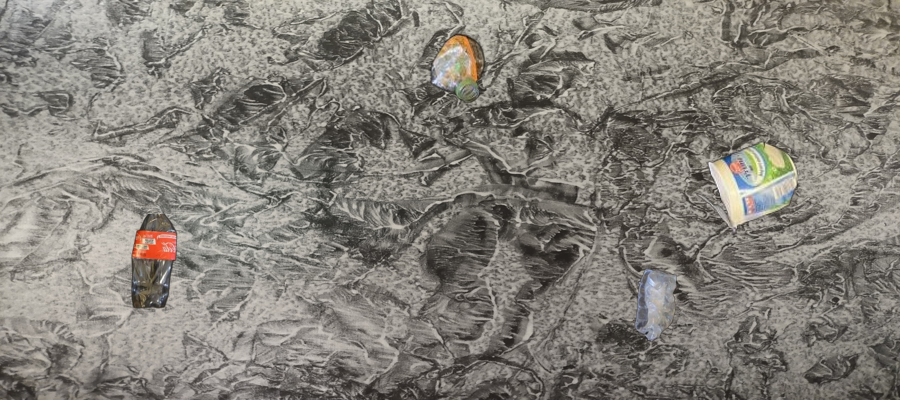

In [273]:
generator.test_resize()